# Automatic Retinal Segmentation

**Project Goal**: To automatically segment out stems within the retinal image as a boolean image

## Method of Ground Truth

The key to this project is **how** the annotator created the ground truth.
By closely replicating their thought process with computational techniques, we can achieve similar results.

However, we'll assume how they did it:
- Remove the background by isolating the biggest ellipse fittable
- Build an annotation image through level bandpass
- Save that initial annotation
- Build another annotation image through level bandpass
- Add that annotation onto the initial one using Union

We'll build a model that replicates that procedure as a baseline.

In [1]:
import matplotlib.pyplot as plt

from image_io import load_images

train_x, train_y, test_x = load_images()

Text(0.5, 1.0, 'Test Image Input')

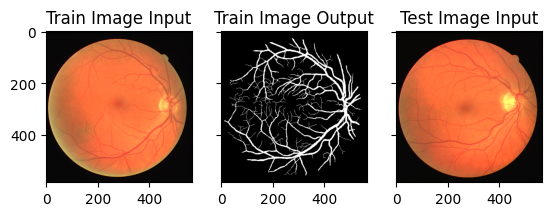

In [2]:
fig, axs = plt.subplots(1, 3, sharey=True)
axs[0].imshow(train_x)
axs[0].set_title("Train Image Input")
axs[1].imshow(train_y, cmap='gray')
axs[1].set_title("Train Image Output")
axs[2].imshow(test_x)
axs[2].set_title("Test Image Input")

# Exploratory Data Analysis

A must for all data science projects, let's take a look at the scope of the data

We'll answer the following questions:
- What is the input shape & range?
- How is the input image range spread?
- What are some interesting features of the data?

## Input Traits

In [3]:
print(train_x.shape)
print(min(train_x.flatten()), max(train_x.flatten()))
print(train_x.dtype)

(584, 565, 3)
0 255
uint8


This is trivial, however, we see that it's constrained to an 8-bit image and is discrete.

## Data Spread

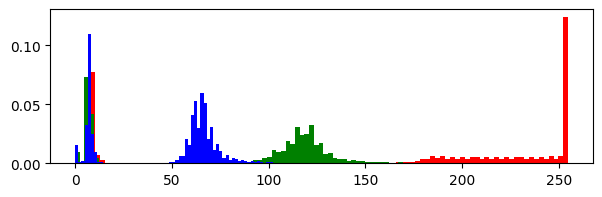

In [4]:
# import seaborn as sns
# fig, axs = plt.subplots(3, 1, sharex=True)
plt.figure(figsize=(7, 2))
for e, (colour, ax) in enumerate(zip(['red', 'green', 'blue'], axs)):
    plt.hist(train_x[..., e].flatten(), bins=100, color=colour, density=True)
    # ax.set_title(f"{colour} channel")

# fig.tight_layout()

We observe 2 anomalies:
 - 1 at the lower ends for all channels
 - 1 at the upper end of red.

Let's segment the image and observe how they relate to the image.

### Lower Anomaly

We'll threshold at 25 on all channels as observed by the histogram

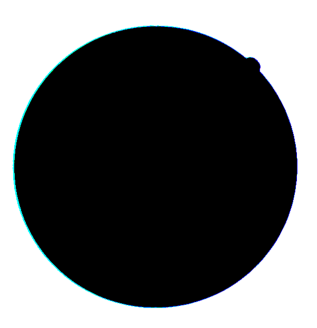

In [5]:
import numpy as np

plt.figure(figsize=(4,4))
plt.axis('off')
_ = plt.imshow(
    (train_x < 25) * 255,
    cmap='gray'
)

Looks like much of the data on the lower end spike is of the background.

### Upper Anomaly

Interestingly, only the red channel has the upper anomaly.
I hypothesize that the red channel has saturated somewhere in the image.

We'll remove all background & red pixels of value 255.

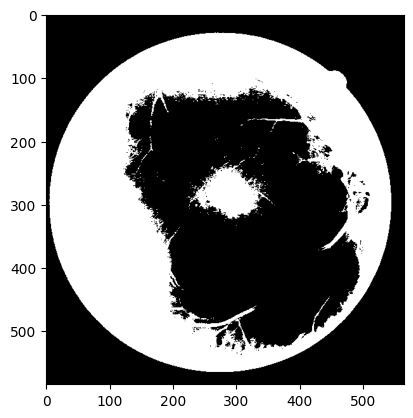

In [6]:
_ = plt.imshow((train_x[..., 0] < 255) & (train_x[..., 0] > 25), cmap='gray')

Seems like many of the red pixels in the foreground are saturated at 255.

# Background Segmentation

Firstly, we'll need to remove the background.

There are 3 crucial steps here:
1) Classify pixels in the background and the foreground (retina)
2) Apply a best-fit circle estimate
3) Remove areas outside the circle

## Background/Foreground Classification
1) **Principal Component Analysis** for Dimensionality Reduction to the highest variance
2) **Gaussian Blur** to remove high frequency noise
3) **Canny Edge Detection** to yield retina edges as boolean map
4) **Contour Detection** to yield contours from boolean map

### Principal Component Analysis
The purpose of PCA is to maximize variance while also reducing dimensionality.
This saves us the trouble of having to find the best channel to segment on (dimensionality reduction) while maximizing variance (for edge detection)

### Gaussian Blur
Canny Edge Detection false positives are susceptible to noise.
To reduce false positives, we lightly smooth the image via a rectangular kernel

### Canny Edge Detection
Canny Edge scans the image with a kernel to find all possible edges.
Important parameters are the Canny Edge minVal & maxVal, which are arguments for a Hysteresis Thresholding algorithm.
This algorithm prevents broken edges by giving it a "leeway" before cutting it off
More information here: https://docs.opencv.org/4.x/da/d22/tutorial_py_canny.html

### Contour Detection
Canny Edge does not return contours, instead it returns a boolean image of edges.
Thus, to find contours we use OpenCV2's `findContours`.
Ref: https://www.sciencedirect.com/science/article/pii/0734189X85900167

The algorithm detects contours through **border following**, yielding our edges as a single connected contour.

However, as observed, we may not have a single contour, bordering the foreground-background.
We will need to remove contours within the foreground if the retinal stems are of high contrast.

We can do so by yielding only the contour of the highest area.

In [7]:
from matplotlib.pyplot import imread
import cv2
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

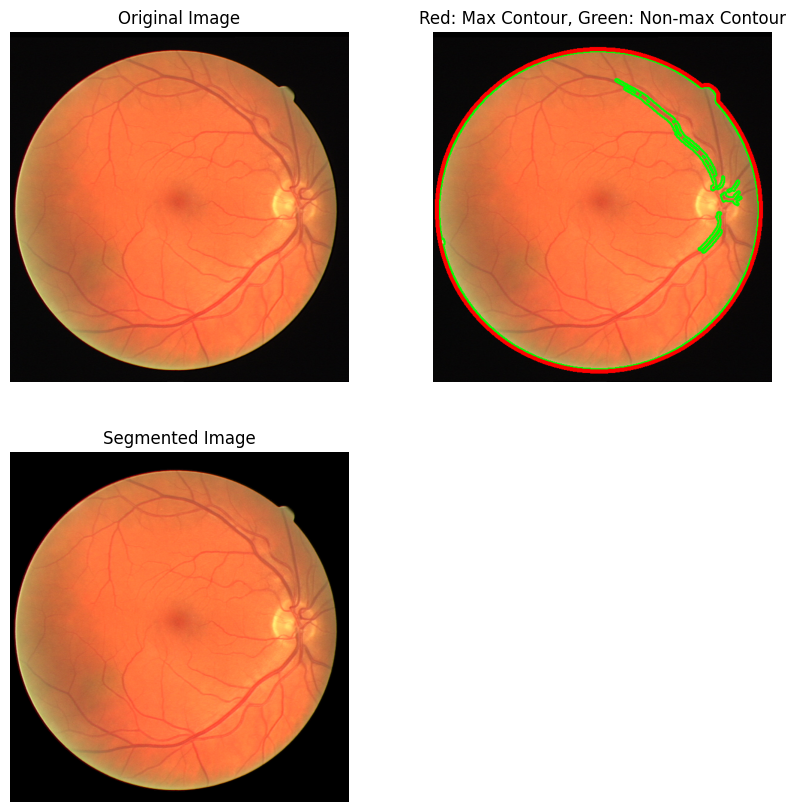

In [8]:
from sklearn.preprocessing import minmax_scale
from skimage.filters.thresholding import threshold_otsu

# Perform PCA to reduce dimensions to 1
pca = PCA(1)
shape = train_x.shape
ar = pca.fit_transform(train_x.reshape(-1, 3))
ar = minmax_scale(ar, (0, 255)).reshape(shape[:-1])

# Reduce high intensity noise
ar = cv2.GaussianBlur(ar, (3, 3), 1)

# Perform Canny Edge Detection
# We'll automatically set the canny thresholds via the image mean
# Based on: http://www.kerrywong.com/2009/05/07/canny-edge-detection-auto-thresholding/
canny_lower, canny_upper = (o := threshold_otsu(ar)) * 0.5, o
ar = cv2.Canny(ar.astype(np.uint8), canny_lower, canny_upper)
ar = cv2.dilate(ar, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))
# We'll extract the contours from the canny
contours, _ = cv2.findContours(ar, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Find the biggest contour
contour_max = max(contours, key=cv2.contourArea)

fg_mask = cv2.drawContours(np.zeros_like(train_x[..., 0]), [contour_max], -1, 1, thickness=cv2.FILLED).astype(bool)
train_fg_x = fg_mask[..., np.newaxis] * train_x
# train_fg_x = np.where(np.repeat(fg_mask[..., np.newaxis], 3, axis=-1), train_x.astype(float) / 255, np.nan)

plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.axis('off')
_ = plt.title("Original Image")
_ = plt.imshow(train_x)

plt.subplot(222)
plt.axis('off')
canvas = cv2.drawContours(train_x.copy(), contours, -1, (0, 255, 0), 2)
canvas = cv2.drawContours(canvas, [contour_max], -1, (255, 0, 0), 5)
_ = plt.imshow(canvas)
_ = plt.title("Red: Max Contour, Green: Non-max Contour")

_ = plt.subplot(223)
plt.axis('off')
_ = plt.title("Segmented Image")
_ = plt.imshow(train_fg_x, cmap='gray')

Doesn't seem like much has changed, (probably for the best).
Let's analyze the histogram again

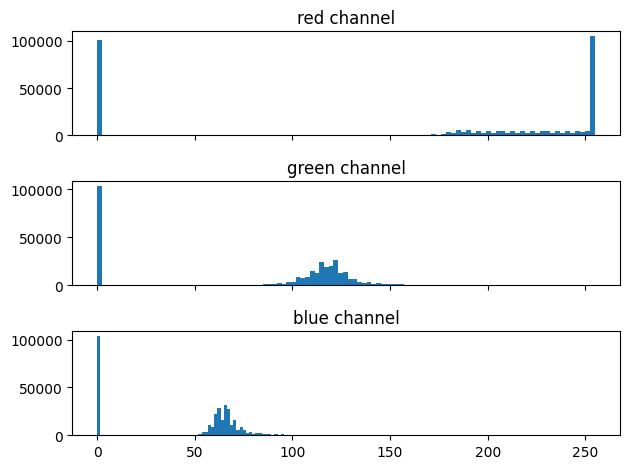

In [9]:
fig, axs = plt.subplots(3, 1, sharex=True)
for e, (colour, ax) in enumerate(zip(['red', 'green', 'blue'], axs)):
    ax.hist(train_fg_x[..., e].flatten(), bins=100)
    ax.set_title(f"{colour} channel")
fig.tight_layout()

Excellent! Now we've set all background values to 0
*Note*: in case there are 0s in the actual image, we use our mask to remove the background instead of querying for zeros.

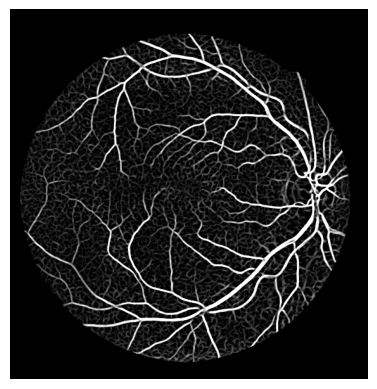

In [10]:
from sklearn.metrics import accuracy_score, f1_score
from skimage.filters.thresholding import threshold_otsu
from skimage.morphology import remove_small_objects


lab = cv2.cvtColor(train_fg_x, cv2.COLOR_RGB2LAB)
lab_planes = list(cv2.split(lab))
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4, 4))
lab_planes[0] = clahe.apply(lab_planes[0])
lab = cv2.merge(lab_planes)
ar = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
ar = cv2.GaussianBlur(ar, (3, 3), 5)
ridge_filter = cv2.ximgproc.RidgeDetectionFilter_create()
ar = cv2.GaussianBlur(ar, (5,5), 1.3)
ar = ridge_filter.getRidgeFilteredImage(ar)
ar *= cv2.erode(fg_mask.astype(np.uint8), np.ones((20, 20)))

plt.axis('off')
plt.imshow(ar, cmap='gray')

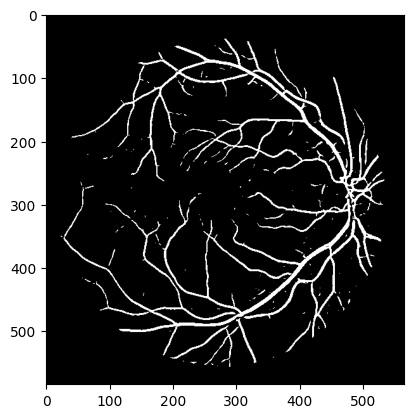

In [11]:
ar = (ar > threshold_otsu(ar)).astype(np.uint8)
plt.imshow(ar, cmap='gray')

0.7625005652953856


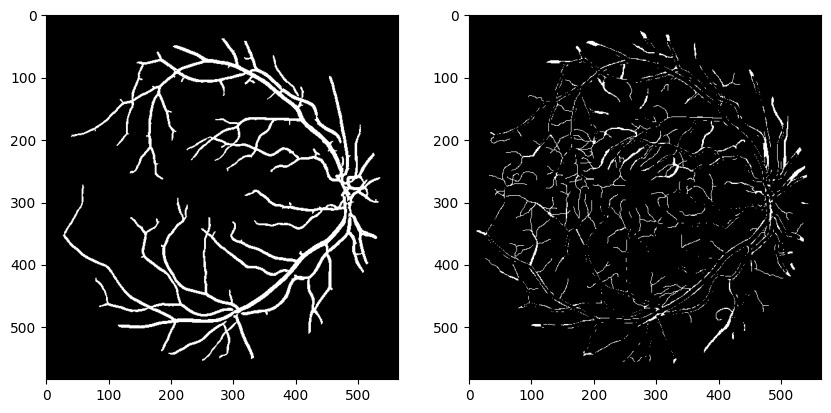

In [12]:
ar = cv2.morphologyEx(
    ar.astype(np.uint8), cv2.MORPH_DILATE,
    cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
)
ar = remove_small_objects(ar.astype(bool), 256)
# plt.imshow(ar, cmap='gray')

print(f1_score(ar.flatten(), train_y.flatten()))

# plt.imshow(ar, cmap='gray')
plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.imshow(ar, cmap='gray')
plt.subplot(122)
plt.imshow(train_y & (~ ar), cmap='gray')

## Best Fit Circle Estimation

We assume that the vessels are within a circle.
This assumption, while not strictly necessary, aids in generalizing to images of poorer quality & of unclear edges.

Observe that the above image has a notch on the upper right, assuming that it's anomalous, we would want to remove it.

http://www.bmva.org/bmvc/1989/avc-89-029.pdf

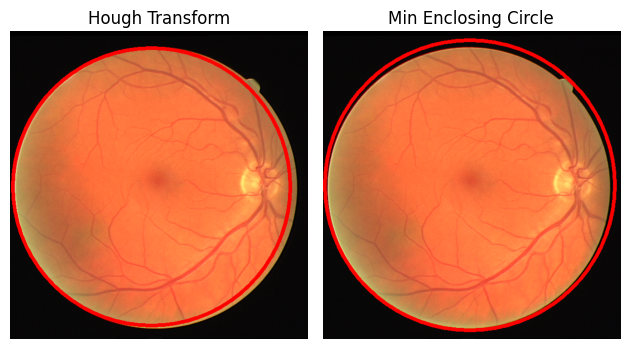

In [23]:
plt.subplot(121)
plt.axis('off')
im = cv2.drawContours(np.zeros_like(train_x[..., 0]), [contour_max], -1, 255, thickness=cv2.FILLED)
circle_x, circle_y, circle_rad = cv2.HoughCircles(im, cv2.HOUGH_GRADIENT, 3, 1, 1)[0, 1]

canvas = train_x.copy()  # ar is grayscale, we expand it to the 3rd dimension to can draw the circle as red.
canvas = cv2.circle(canvas, (int(circle_x), int(circle_y)), int(circle_rad), 255, 5)
_ = plt.imshow(canvas, cmap='gray')
plt.title("Hough Transform")

plt.subplot(122)
plt.axis('off')
# Yield the Minimum Enclosing Circle
(circle_x, circle_y), circle_rad = cv2.minEnclosingCircle(contour_max)

# Draw it out
canvas = train_x.copy()  # ar is grayscale, we expand it to the 3rd dimension to can draw the circle as red.
canvas = cv2.circle(canvas, (int(circle_x), int(circle_y)), int(circle_rad), 255, 5)
_ = plt.imshow(canvas, cmap='gray')
plt.title("Min Enclosing Circle")
_ = plt.tight_layout()